# Binary classification models

In [89]:
import numpy as np
import pandas as pd 
import matplotlib as mpl   
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.signal import find_peaks, savgol_filter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout
# from keras.utils import to_categorical
# import glob

In [2]:
data = pd.read_csv("../input/data.csv")

In [3]:
display(data.tail().T, data.shape)

,84,85,86,87,88
320,-6.045785,-31.838142,24.793552,-17.652415,10.166875
321,-2.643846,-15.583373,9.836824,-8.010407,17.069577
322,5.90005,-2.133733,-5.213078,0.189554,18.806734
323,26.189564,-0.542107,-17.161635,4.889334,10.689331
324,50.332134,-3.355853,-23.770711,10.708648,-1.810575
...,...,...,...,...,...
1648,-11.094865,-1.922447,15.928893,-6.342218,-4.904049
1649,-1.680172,3.625427,-1.459799,4.096149,14.514866
1650,11.265595,-4.314838,-8.896405,3.117341,9.982839
Diagnostic,VLP,VLP,VLP,VLP,VLP


(89, 1333)

## Data prepration

In [4]:
def preprocess_data(data):

    X = data.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
    X.columns = X.columns.astype(int)
    y = data['COVID-19_Status']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, X_test, y_train_encoded, y_test_encoded

## Simple Neural Network

In [5]:
NUM_EPOCHS = 30

In [15]:
X_train, X_test, y_train, y_test = preprocess_data(data)

In [16]:
def simple_nn(X_train, X_test, y_train, y_test, num_epochs=30):
    model = Sequential([
        Dense(2048, input_dim= X_train.shape[1], activation='relu'),
        Dense(1024, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for i in range(num_epochs):
        history = model.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

        test_loss.append(loss)
        test_accuracy.append(accuracy)
        print(f'Epoch {i+1} => Test Loss: {loss:.2f} - Test Accuracy: {accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    # plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    # plt.plot(test_loss, label='test_loss')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show() 
    return model

In [ ]:
simple_model = simple_nn(X_train, X_test, y_train, y_test)

2/2 [==============================] - 0s 3ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

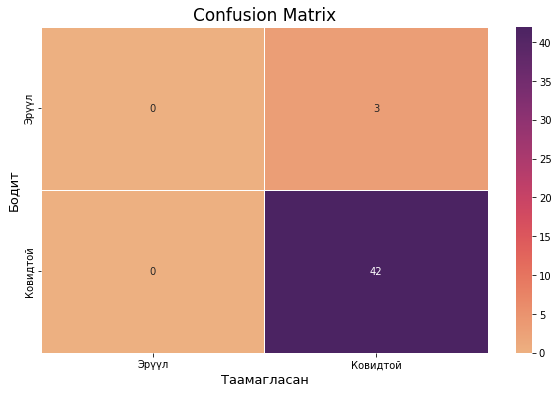

In [84]:
y_pred = simple_model.predict(X_test)
y_pred = y_pred.astype(int).reshape(-1)
display(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(cm, 
            ax=ax,
            annot=True,
            cmap="flare",
            linewidth=.5,
            fmt='g', 
            xticklabels=['Эрүүл','Ковидтой'],
            yticklabels=['Эрүүл','Ковидтой'])
plt.xlabel('Таамагласан',fontsize=13)
plt.ylabel('Бодит',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

0

3

0

42

In [99]:
tp, fn, fp, tn = cm.ravel()
print(f"TP: {tp} FN: {fn} \nFP: {fp} TN: {tn}")

sensitivity = recall_score(y_test, y_pred)
sensitivity_ = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.4f}")

print(f"Sensitivity: {sensitivity_:.4f}")
print(f"Specificity: {specificity:.4f}")

TP: 0 FN: 3 
FP: 0 TN: 42
Sensitivity: 1.0000
Sensitivity: 0.0000
Specificity: 1.0000


## CNN (Convolution Neural Network) model

In [127]:
def simple_cnn(X_train, X_test, y_train, y_test, num_epochs=30):

    model = Sequential([
        Conv1D(16, 21, input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(16),
        Dropout(0.1),

        Conv1D(32, 11),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(8),
        Dropout(0.1),

        Conv1D(64, 5),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(4),
        
        Flatten(),
        BatchNormalization(),

        Dense(2048, activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for i in range(num_epochs):
        history = model.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

        test_loss.append(loss)
        test_accuracy.append(accuracy)
        if (i + 1) % 5 == 0:
            print(f'Epoch {i+1} => Test Loss: {loss:.2f} - Test Accuracy: {accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    # plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    # plt.plot(test_loss, label='test_loss')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show()

    return model

Epoch 5 => Test Loss: 0.36 - Test Accuracy: 93.33%
Epoch 10 => Test Loss: 0.22 - Test Accuracy: 93.33%
Epoch 15 => Test Loss: 0.19 - Test Accuracy: 93.33%
Epoch 20 => Test Loss: 0.16 - Test Accuracy: 93.33%
Epoch 25 => Test Loss: 0.18 - Test Accuracy: 93.33%
Epoch 30 => Test Loss: 0.16 - Test Accuracy: 95.56%


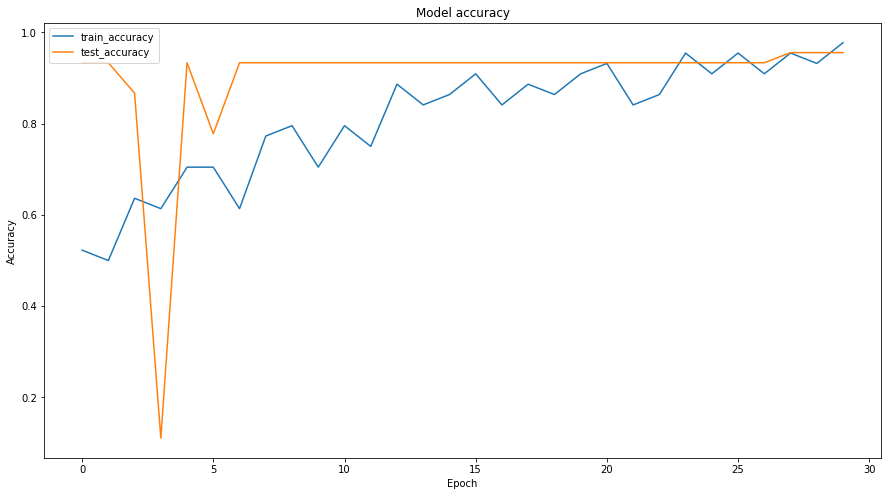

In [128]:
simple_cnn_model = simple_cnn(X_train, X_test, y_train, y_test)

2/2 [==============================] - 0s 3ms/step


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


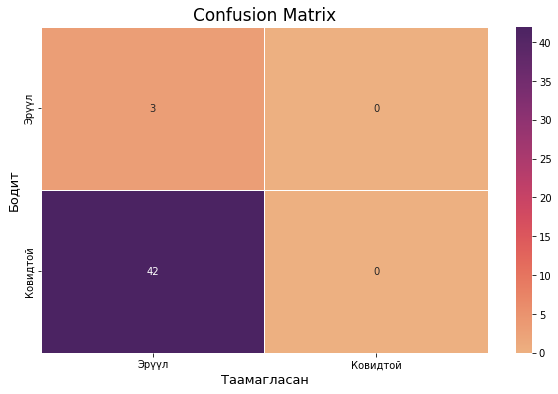

In [129]:
y_pred = simple_cnn_model.predict(X_test)
y_pred = y_pred.astype(int).reshape(-1)
display(pd.DataFrame(y_test).T, pd.DataFrame(y_pred).T)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(cm, 
            ax=ax,
            annot=True,
            cmap="flare",
            linewidth=.5,
            fmt='g', 
            xticklabels=['Эрүүл','Ковидтой'],
            yticklabels=['Эрүүл','Ковидтой'])
plt.xlabel('Таамагласан',fontsize=13)
plt.ylabel('Бодит',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [126]:
tp, fn, fp, tn = cm.ravel()
print(f"TP: {tp} FN: {fn} \nFP: {fp} TN: {tn}")

sensitivity = recall_score(y_test, y_pred)
sensitivity_ = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.4f}")

print(f"Sensitivity: {sensitivity_:.4f}")
print(f"Specificity: {specificity:.4f}")

TP: 3 FN: 0 
FP: 42 TN: 0
Sensitivity: 0.0000
Sensitivity: 1.0000
Specificity: 0.0000


## SVM (Support Vector Machine) model

## Report